# Imports and functions

In [1]:
import pandas as pd
import numpy as np
import math

# plotting and mapping
import matplotlib.pyplot as plt
import contextily as cx

# handling trajectory and other geo-data
import geopandas as gpd
import shapely as shp
from shapely.geometry import Point, LineString, MultiLineString
from shapely import to_geojson, from_geojson, get_point, get_parts

# create road network graph from OSM data
import osmnx as ox
import networkx as nx

# Some filepaths
points_file = '../Data/gbg_trajectories_points_2019.csv'
trajs_file = '../Data/gbg_trajectories_2019_crossing.csv'
points_pickle_file = '../Data/points.pkl'
trajs_pickle_file = '../Data/trajectories.pkl'

In [2]:
def calculate_heading(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta_rad = math.atan2(delta_x, delta_y)
    theta_deg = math.degrees(theta_rad)
    if theta_deg < 0:
        theta_deg += 360
    return theta_deg

def get_headings(linestring):
    coords = list(linestring.coords)
    headings = []
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        heading = calculate_heading(x1, y1, x2, y2)
        headings.append(heading)
    return np.mean(headings)

# def get_headings(linestring):
#     coords = list(linestring.coords)
#     headings = []
#     for i in range(len(coords) - 1):
#         x1, y1 = coords[i]
#         x2, y2 = coords[i+1]
#         heading = calculate_heading(x1, y1, x2, y2)
#         headings.append(heading)
#     return [headings[0], headings[-1]]

# Loading data

In [3]:
# around 3-4 minutes run time
points_df = pd.read_pickle(points_pickle_file)
display(points_df.head())
trajs_df = pd.read_pickle(trajs_pickle_file)
display(trajs_df.head())

,,x,y,timestamp,trajectory_sid
,trajectory_sid,,,,
945076,1,323265.332049,6.417527e+06,2019-09-04 15:58:09+02:00,1
945077,1,323200.761503,6.417410e+06,2019-09-04 15:58:14+02:00,1
945078,1,323140.136125,6.417293e+06,2019-09-04 15:58:19+02:00,1
945079,1,323087.578794,6.417171e+06,2019-09-04 15:58:24+02:00,1
945080,1,323043.302414,6.417045e+06,2019-09-04 15:58:29+02:00,1


,start_time,stop_time,duration,data_points,distance,speed,line
sid,,,,,,,
1,2019-09-04 15:18:24+02:00,2019-09-04 16:03:24+02:00,2700,541,64885,86.513333,LINESTRING (342610.0375303831 6464707.88746338...
3,2019-10-19 18:55:00+02:00,2019-10-19 20:54:12+02:00,7152,1429,206390,103.887584,LINESTRING (324460.85687151505 6386857.1792007...
4,2019-10-28 04:13:07+01:00,2019-10-28 05:14:17+01:00,3670,648,96755,94.909537,LINESTRING (321475.2318731322 6398016.73146137...
7,2019-11-23 09:10:37+01:00,2019-11-23 10:06:47+01:00,3370,670,77225,82.495549,LINESTRING (329279.0401737231 6403344.89584320...
11,2019-09-16 18:05:00+02:00,2019-09-16 18:53:53+02:00,2933,507,75961,93.235459,LINESTRING (320825.56008272676 6399036.5784418...


In [4]:
points_df.drop('trajectory_sid', axis=1, inplace=True)

In [5]:
points_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.x, points_df.y), crs = 'EPSG:3006') # don't forget crs = 'EPSG:3006'
display(points_gdf.sample(5))
del points_df
trajs_gdf = gpd.GeoDataFrame(trajs_df, geometry='line', crs='EPSG:3006')
display(trajs_gdf.sample(5))
del trajs_df

,,x,y,timestamp,geometry
,trajectory_sid,,,,
91934,30930,325626.982234,6.396114e+06,2019-09-13 16:12:49+02:00,POINT (325626.982 6396114.151)
4907697,3506642,322915.663850,6.390614e+06,2019-08-12 14:07:00+02:00,POINT (322915.664 6390614.009)
6508455,5013840,324767.408876,6.405812e+06,2019-06-05 13:01:06+02:00,POINT (324767.409 6405811.552)
11876541,9688565,308454.222080,6.388668e+06,2019-08-21 04:41:16+02:00,POINT (308454.222 6388667.799)
8817658,6973121,314923.800481,6.402250e+06,2019-08-16 16:43:27+02:00,POINT (314923.800 6402250.420)


,start_time,stop_time,duration,data_points,distance,speed,line
sid,,,,,,,
8175767,2019-06-11 16:30:05+02:00,2019-06-11 16:30:10+02:00,5,2,5,3.600000,"LINESTRING (320984.876 6397627.191, 320987.949..."
9531186,2019-07-09 07:36:14+02:00,2019-07-09 07:36:29+02:00,15,2,38,9.120000,"LINESTRING (312506.229 6400355.529, 312472.412..."
115711,2019-09-17 11:34:50+02:00,2019-09-17 11:34:54+02:00,4,2,5,4.500000,"LINESTRING (314690.621 6403101.463, 314685.416..."
2814629,2019-06-20 22:29:27+02:00,2019-06-20 22:32:33+02:00,186,2,355,6.870968,"LINESTRING (323808.244 6407036.859, 324161.973..."
6703679,2019-07-21 10:10:35+02:00,2019-07-21 10:10:40+02:00,5,2,15,10.800000,"LINESTRING (319276.233 6397814.675, 319271.929..."


In [6]:
# replace traj_id to export that single trajectory to geojson
# traj_id = 5687165
# with open(f'../Data/QGIS/traj_{traj_id}.geojson', 'w') as f:
#     f.write(to_geojson(trajs_gdf.loc[traj_id].line))

In [7]:
trajs_gdf.info(), points_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2519482 entries, 1 to 9864767
Data columns (total 7 columns):
 #   Column       Dtype   
---  ------       -----   
 0   start_time   object  
 1   stop_time    object  
 2   duration     uint32  
 3   data_points  uint32  
 4   distance     uint32  
 5   speed        float64 
 6   line         geometry
dtypes: float64(1), geometry(1), object(2), uint32(3)
memory usage: 124.9+ MB
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 13564236 entries, (945076, 1) to (552533, 9864767)
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   x          float64 
 1   y          float64 
 2   timestamp  object  
 3   geometry   geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 641.0+ MB


(None, None)

In [8]:
points_gdf

,,x,y,timestamp,geometry
,trajectory_sid,,,,
945076,1,323265.332049,6.417527e+06,2019-09-04 15:58:09+02:00,POINT (323265.332 6417527.432)
945077,1,323200.761503,6.417410e+06,2019-09-04 15:58:14+02:00,POINT (323200.762 6417410.436)
945078,1,323140.136125,6.417293e+06,2019-09-04 15:58:19+02:00,POINT (323140.136 6417292.709)
945079,1,323087.578794,6.417171e+06,2019-09-04 15:58:24+02:00,POINT (323087.579 6417170.725)
945080,1,323043.302414,6.417045e+06,2019-09-04 15:58:29+02:00,POINT (323043.302 6417045.254)
...,...,...,...,...,...
552529,9864767,320895.068550,6.417215e+06,2019-10-22 04:50:05+02:00,POINT (320895.069 6417215.083)
552530,9864767,320791.194469,6.417291e+06,2019-10-22 04:50:10+02:00,POINT (320791.194 6417290.740)
552531,9864767,320698.473931,6.417370e+06,2019-10-22 04:50:15+02:00,POINT (320698.474 6417369.914)


the below grouping is not necessary for this investigation

In [9]:
# group points by trajectory_sid and sort by timestamp to get an ordered list of points for each trajectory
# runtime: 1-3 minutes
# grouped_points = points_gdf.groupby("trajectory_sid")["timestamp"].apply(list).reset_index()

In [10]:
# grouped_points.set_index('trajectory_sid', drop=True, inplace=True)
# grouped_points

## Road sections

In [11]:
# set variables used in section
buffer_distance = 20

In [12]:
#road_cong_points = [LineString([(322169, 6411344), (322081, 6412907)]), LineString([(322108, 6408320), (322143, 6408455)]), LineString([(323509, 6402118), (323445, 6402093)]), LineString([(321349, 6397697), (321290, 6397846)]), LineString([(322376, 6396936), (322191, 6397229)])]
road_cong_lines = []
road_cong_names = ["angered", "agnesberg", "torpamotet", "kallebäck", "riksväg_40"]

#road_free_points = [LineString([(317457, 6393404), (317675, 6393394)]), LineString([(316999, 6390947), (317122, 6390534)]), LineString([(316677, 6399129), (316534, 6399076)]), LineString([(322608, 6392581), (322467, 6392879)]), LineString([(330496, 6403701), (330326, 6403656)])]
road_free_lines = []
road_free_names = ["järnbrottet", "askim", "oscarleden", "åbymotet", "jonsered"]

# read congested road section lines from files
for section_name in road_cong_names:
    with open(f'geometries/cong/{section_name}_line.geojson', 'r') as f:
        road_cong_lines.append(get_parts(from_geojson(f.read()),0)[0])

# read free-flow road section lines from files
for section_name in road_free_names:
    with open(f'geometries/free/{section_name}_line.geojson', 'r') as f:
        road_free_lines.append(get_parts(from_geojson(f.read()),0)[0])

display(road_cong_lines, road_free_lines)

[<LINESTRING (322097.49 6412333.009, 322106.528 6412215.173)>,
 <LINESTRING (322141.356 6408452.193, 322111.031 6408337.968)>,
 <LINESTRING (323288.747 6402024.456, 323175.967 6401989.135)>,
 <LINESTRING (321307.558 6397804.389, 321350.173 6397694.157)>,
 <LINESTRING (322256.228 6397126.535, 322319.44 6397026.679)>]

[<LINESTRING (317621.684 6393394.498, 317503.651 6393400.445)>,
 <LINESTRING (317033.168 6390805.29, 317065.113 6390691.507)>,
 <LINESTRING (316665.552 6399126.031, 316554.499 6399085.604)>,
 <LINESTRING (322514.004 6392775.229, 322564.62 6392668.435)>,
 <LINESTRING (330469.764 6403696.764, 330355.356 6403667.139)>]

In [13]:
buffered_cong_road_sections = []
for line in road_cong_lines:
    buffered_cong_road_sections.append(line.buffer(buffer_distance))

buffered_cong_road_sections

[<POLYGON ((322126.47 6412216.702, 322126.524 6412214.74, 322126.385 6412212....>,
 <POLYGON ((322130.362 6408332.836, 322129.766 6408330.966, 322128.989 640832...>,
 <POLYGON ((323181.944 6401970.049, 323180.045 6401969.555, 323178.106 640196...>,
 <POLYGON ((321368.827 6397701.369, 321369.444 6397699.506, 321369.876 639769...>,
 <POLYGON ((322336.339 6397037.377, 322337.306 6397035.669, 322338.101 639703...>]

In [14]:
buffered_free_road_sections = []
for line in road_free_lines:
    buffered_free_road_sections.append(line.buffer(buffer_distance))

buffered_free_road_sections

[<POLYGON ((317502.645 6393380.47, 317500.692 6393380.665, 317498.767 6393381...>,
 <POLYGON ((317084.368 6390696.913, 317084.805 6390695, 317085.053 6390693.05...>,
 <POLYGON ((316561.341 6399066.81, 316559.466 6399066.23, 316557.543 6399065....>,
 <POLYGON ((322582.693 6392677.001, 322583.445 6392675.188, 322584.017 639267...>,
 <POLYGON ((330360.369 6403647.778, 330358.447 6403647.38, 330356.495 6403647...>]

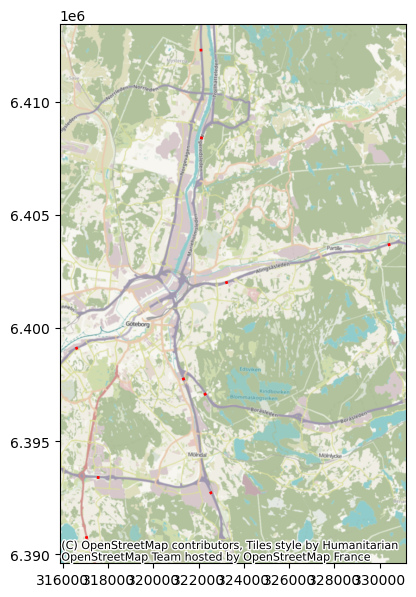

In [15]:
road_sections_gdf = gpd.GeoDataFrame(geometry=road_cong_lines + road_free_lines, crs='EPSG:3006')
#display(road_sections_gdf)

# plot road sections on map
ax = road_sections_gdf.plot(color='red', figsize=(7,7), linewidth=2)
cx.add_basemap(ax, crs=road_sections_gdf.crs.to_string())

In [16]:
# write buffered road section geometries to file 
# print('Congested road sections:')
# for section_name, section_line in zip(road_cong_names, buffered_cong_road_sections):
#     with open(f'geometries/cong/{section_name}.geojson', 'w') as f:
#         f.write(to_geojson(section_line))
#         print(f'geometries/cong/{section_name}.geojson done.')
# print('Free-flow road sections:')
# for section_name, section_line in zip(road_free_names, buffered_free_road_sections):
#     with open(f'geometries/free/{section_name}.geojson', 'w') as f:
#         f.write(to_geojson(section_line))
#         print(f'geometries/free/{section_name}.geojson done.')

In [17]:
# write LineStrings to file 
# print('Congested road sections:')
# for section_name, section_line in zip(road_cong_names, road_cong_lines):
#     with open(f'geometries/cong/{section_name}_line.geojson', 'w') as f:
#         f.write(to_geojson(section_line))
#         print(f'geometries/cong/{section_name}_line.geojson done.')
# print('Free-flow road sections:')
# for section_name, section_line in zip(road_free_names, road_free_lines):
#     with open(f'geometries/free/{section_name}_line.geojson', 'w') as f:
#         f.write(to_geojson(section_line))
#         print(f'geometries/free/{section_name}_line.geojson done.')

# Creating the dataframe with trajs and timestamps
Should not be necessary! Rerun the cell below rather than all of the above

In [18]:
# traj_with_timestamps_df = pd.merge(trajs_gdf, grouped_points, left_index=True, right_index=True, how="inner") #right_on="trajectory_sid"
# traj_with_timestamps_df.info()

# Check intersection 

## Old code

In [19]:
# create a column for each road section, True if trajectory intersects the road section, else False
# runtime: 3-4 min
# for idx, section_name in enumerate(road_cong_names):
#     # Create a buffered polygon around the road section
#     road_section = buffered_cong_road_sections[idx]
#     # make a column with True if trajectory intersects buffered road section, else False
#     traj_with_timestamps_df[section_name] = traj_with_timestamps_df.line.apply(lambda x: x.intersects(road_section))
#     print(section_name, 'done.')


In [20]:
# filter only the trajectories that intersect with the road sections
# traj_with_timestamps_df = traj_with_timestamps_df[(traj_with_timestamps_df["angered"] == 1) | (traj_with_timestamps_df["agnesberg"] == 1) | (traj_with_timestamps_df["torpamotet"] == 1) | (traj_with_timestamps_df["riksväg_40"] == 1)].reset_index(drop=True)
# traj_with_timestamps_df.shape

## New code

In [21]:
# try the same as above but with a spatial join instead
# runtime: 30-40 sec
for idx, section_name in enumerate(road_cong_names):
    # Fetch the buffered polygon around the road section
    road_section = buffered_cong_road_sections[idx]
    # Merge the road section with the trajectories on the traj intersecting
    smerged_gdf = gpd.sjoin(gpd.GeoDataFrame(geometry=[road_section], crs='EPSG:3006'),
                            trajs_gdf, how='right', predicate='intersects')
    # make a column with True if trajectory intersects road section, else False
    trajs_gdf[section_name] = smerged_gdf.index_left.notna()
    print(section_name, 'done.')


angered done.
agnesberg done.
torpamotet done.
kallebäck done.
riksväg_40 done.


In [22]:
# same but for free-flow road sections
# runtime: 30-40 sec
for idx, section_name in enumerate(road_free_names):
    # Fetch the buffered polygon around the road section
    road_section = buffered_free_road_sections[idx]
    # Merge the road section with the trajectories on the traj intersecting
    smerged_gdf = gpd.sjoin(gpd.GeoDataFrame(geometry=[road_section], crs='EPSG:3006'),
                            trajs_gdf, how='right', predicate='intersects')
    # make a column with True if trajectory intersects road section, else False
    trajs_gdf[section_name] = smerged_gdf.index_left.notna()
    print(section_name, 'done.')


järnbrottet done.
askim done.
oscarleden done.
åbymotet done.
jonsered done.


# Filter intersecting trajectories

Rerun cell below to recreate the filtered gdf from trajs_gdf with intersecting-check done.

In [23]:
idxs_to_keep = set()
for section_name in (road_cong_names + road_free_names):
    section_idxs = trajs_gdf[trajs_gdf[section_name]].index
    idxs_to_keep.update(section_idxs)

trajs_gdf_filtered = trajs_gdf.loc[list(idxs_to_keep)].sort_index()
trajs_gdf_filtered.shape   

(27584, 17)

In [24]:
trajs_gdf_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27584 entries, 4 to 9864767
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   start_time   27584 non-null  object  
 1   stop_time    27584 non-null  object  
 2   duration     27584 non-null  uint32  
 3   data_points  27584 non-null  uint32  
 4   distance     27584 non-null  uint32  
 5   speed        27584 non-null  float64 
 6   line         27584 non-null  geometry
 7   angered      27584 non-null  bool    
 8   agnesberg    27584 non-null  bool    
 9   torpamotet   27584 non-null  bool    
 10  kallebäck    27584 non-null  bool    
 11  riksväg_40   27584 non-null  bool    
 12  järnbrottet  27584 non-null  bool    
 13  askim        27584 non-null  bool    
 14  oscarleden   27584 non-null  bool    
 15  åbymotet     27584 non-null  bool    
 16  jonsered     27584 non-null  bool    
dtypes: bool(10), float64(1), geometry(1), object(2), uint32(3)
memor

# Filter coords and timestamps

maybe not necessary...


In [25]:
def extract_coords_and_time(line, timestamps, point1, point2):
    coords = list(line.coords)

    distance_p1 = [Point(pt).distance(point1) for pt in coords]
    distance_p2 = [Point(pt).distance(point2) for pt in coords]
    # print(distance_p1)
    # print(distance_p2)

    closest_index_p1 = distance_p1.index(min(distance_p1))
    closest_index_p2 = distance_p2.index(min(distance_p2))
    # print(f"close index p1: {closest_index_p1}. Close index p2: {closest_index_p2}")
    # print(f"distance_p1: {min(distance_p1)}. Distance p2 {min(distance_p2)}")

    # Extract the segment between the closest points
    filtered_coords = coords[closest_index_p1:closest_index_p2 + 1]
    filtered_timestamps = timestamps[closest_index_p1:closest_index_p2 + 1]

    if len(filtered_coords) < 2:
        return None, None

    return LineString(filtered_coords), filtered_timestamps

# Clipped trajectories

In [26]:
# define the acceptable enter and exit angles for each road section
cong_road_headings = {}
for idx, section_name in enumerate(road_cong_names):
    section_heading = get_headings(road_cong_lines[idx])
    cong_road_headings[section_name] = [((section_heading-10)%360, (section_heading+10)%360), ((section_heading-190)%360, (section_heading+190)%360)]

In [27]:
cong_road_headings

{'angered': [(165.6141037975222, 185.6141037975222),
  (345.6141037975222, 5.614103797522205)],
 'agnesberg': [(184.8680947549361, 204.8680947549361),
  (4.868094754936095, 24.868094754936124)],
 'torpamotet': [(242.61013190262807, 262.61013190262804),
  (62.61013190262807, 82.61013190262804)],
 'kallebäck': [(148.86389331191623, 168.86389331191623),
  (328.86389331191623, 348.86389331191623)],
 'riksväg_40': [(137.66448021270747, 157.66448021270747),
  (317.6644802127075, 337.6644802127075)]}

In [28]:
free_road_headings = {}
for idx, section_name in enumerate(road_free_names):
    section_heading = get_headings(road_free_lines[idx])
    free_road_headings[section_name] = [((section_heading-10)%360, (section_heading+10)%360), ((section_heading-190)%360, (section_heading+190)%360)]
free_road_headings

{'järnbrottet': [(262.8845632974072, 282.8845632974072),
  (82.88456329740723, 102.88456329740723)],
 'askim': [(154.3178730594462, 174.3178730594462),
  (334.31787305944624, 354.31787305944624)],
 'oscarleden': [(239.99669204884617, 259.99669204884617),
  (59.99669204884617, 79.99669204884617)],
 'åbymotet': [(144.64096843829407, 164.64096843829407),
  (324.64096843829407, 344.64096843829407)],
 'jonsered': [(245.48308841213213, 265.48308841213213),
  (65.48308841213213, 85.48308841213213)]}

In [29]:
all_road_headings = cong_road_headings | free_road_headings
all_road_headings

{'angered': [(165.6141037975222, 185.6141037975222),
  (345.6141037975222, 5.614103797522205)],
 'agnesberg': [(184.8680947549361, 204.8680947549361),
  (4.868094754936095, 24.868094754936124)],
 'torpamotet': [(242.61013190262807, 262.61013190262804),
  (62.61013190262807, 82.61013190262804)],
 'kallebäck': [(148.86389331191623, 168.86389331191623),
  (328.86389331191623, 348.86389331191623)],
 'riksväg_40': [(137.66448021270747, 157.66448021270747),
  (317.6644802127075, 337.6644802127075)],
 'järnbrottet': [(262.8845632974072, 282.8845632974072),
  (82.88456329740723, 102.88456329740723)],
 'askim': [(154.3178730594462, 174.3178730594462),
  (334.31787305944624, 354.31787305944624)],
 'oscarleden': [(239.99669204884617, 259.99669204884617),
  (59.99669204884617, 79.99669204884617)],
 'åbymotet': [(144.64096843829407, 164.64096843829407),
  (324.64096843829407, 344.64096843829407)],
 'jonsered': [(245.48308841213213, 265.48308841213213),
  (65.48308841213213, 85.48308841213213)]}

In [30]:


cong_dist_points = {section_name: [[get_point(road_cong_lines[idx], 0),
                                     get_point(road_cong_lines[idx], 1)],
                                    cong_road_headings[section_name]] \
                                        for idx, section_name in enumerate(road_cong_names)}

free_dist_points = {section_name: [[get_point(road_free_lines[idx], 0),
                                    get_point(road_free_lines[idx], 1)],
                                    free_road_headings[section_name]] \
                                        for idx, section_name in enumerate(road_free_names)}

# initialize clipping gdf
columns=[name + '_clipped' for name in (road_cong_names+road_free_names)]
clipped_trajectories = pd.DataFrame(index=trajs_gdf_filtered.index, columns=columns)
for idx, section_name in enumerate(road_cong_names+road_free_names):
    mask = trajs_gdf_filtered[section_name] == 1
    trajectory_buffer = (buffered_cong_road_sections+buffered_free_road_sections)[idx] 
    
    
    clipped_trajectories[section_name + '_clipped'] = gpd.clip(trajs_gdf_filtered.line, trajectory_buffer)
    print(section_name, 'clipped')

display(clipped_trajectories.sample(5))

#traj_with_timestamps_df.set_geometry(col='clipped_trajectories', inplace=True)
#display(traj_with_timestamps_df)

# for idx, section_name in enumerate(road_cong_names):
#     POINT1, POINT2 = cong_dist_points[section_name][0]
    
#     mask = traj_with_timestamps_df[section_name] == 1

#     def wrapper(row):
#         return extract_coords_and_time(row['clipped_trajectories'], row['timestamp'], POINT1, POINT2)
    
#     filtered_data = traj_with_timestamps_df[mask].apply(wrapper, axis=1, result_type="expand")
    
#     traj_with_timestamps_df.loc[mask, 'filtered_trajectory'] = filtered_data[0]
#     traj_with_timestamps_df.loc[mask, 'filtered_timestamps'] = filtered_data[1]
#     print('1 congested road handled')

# # same for free-flow roads
# for section_name in road_free_names:
#     POINT1, POINT2 = free_dist_points[section_name][0]
    
#     mask = traj_with_timestamps_df[section_name] == 1
    
#     def wrapper(row):
#         return extract_coords_and_time(row['line'], row['timestamp'], POINT1, POINT2)
    
#     filtered_data = traj_with_timestamps_df[mask].apply(wrapper, axis=1, result_type="expand")
    
#     traj_with_timestamps_df.loc[mask, 'filtered_trajectory'] = filtered_data[0]
#     traj_with_timestamps_df.loc[mask, 'filtered_timestamps'] = filtered_data[1]
#     print('1 free-flow road handled')

angered clipped
agnesberg clipped
torpamotet clipped
kallebäck clipped
riksväg_40 clipped
järnbrottet clipped
askim clipped
oscarleden clipped
åbymotet clipped
jonsered clipped


,angered_clipped,agnesberg_clipped,torpamotet_clipped,kallebäck_clipped,riksväg_40_clipped,järnbrottet_clipped,askim_clipped,oscarleden_clipped,åbymotet_clipped,jonsered_clipped
sid,,,,,,,,,,
2941106,None,None,None,"LINESTRING (321366.339 6397682.405, 321344.734...",None,None,None,None,"LINESTRING (322582.058 6392658.683, 322556.807...",None
1640626,None,None,None,None,None,None,None,"LINESTRING (316680.722 6399139.030, 316591.996...",None,None
9804979,None,None,None,"LINESTRING (321367.776 6397684.699, 321366.850...",None,None,None,None,"LINESTRING (322583.029 6392660.679, 322560.917...",None
1300546,None,None,None,None,"LINESTRING (322237.362 6397133.134, 322264.356...",None,None,None,None,None
4977674,None,None,None,None,None,None,None,None,None,"LINESTRING (330484.937 6403709.759, 330426.183..."


In [31]:
clipped_trajectories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27584 entries, 4 to 9864767
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   angered_clipped      4283 non-null   geometry
 1   agnesberg_clipped    2443 non-null   geometry
 2   torpamotet_clipped   4024 non-null   geometry
 3   kallebäck_clipped    6034 non-null   geometry
 4   riksväg_40_clipped   4015 non-null   geometry
 5   järnbrottet_clipped  3355 non-null   geometry
 6   askim_clipped        1649 non-null   geometry
 7   oscarleden_clipped   2559 non-null   geometry
 8   åbymotet_clipped     5645 non-null   geometry
 9   jonsered_clipped     2127 non-null   geometry
dtypes: geometry(10)
memory usage: 2.3 MB


In [32]:
# angered_ismulti = clipped_trajectories[clipped_trajectories.angered_clipped.notna()].\
#     angered_clipped.map(lambda x: isinstance(x, MultiLineString))
# angered_ismulti_idx = angered_ismulti.loc[angered_ismulti].index
# clipped_trajectories.angered_clipped.loc[angered_ismulti_idx] = \
#     clipped_trajectories.loc[angered_ismulti_idx].angered_clipped.map(lambda x: get_parts(x)[0])


The MultiLineStrings are 1% of total number of geometries. We will disregard them for now, perhaps later discuss assumption that most of them are u-turners. Here is a small sample of them.

angered_clipped
False    27563
True        21
Name: count, dtype: int64
trajectory_sid: 6489265


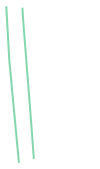

trajectory_sid: 1197935


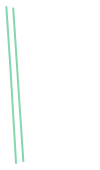

trajectory_sid: 9350285


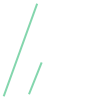

trajectory_sid: 5223903


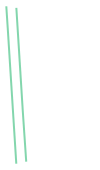

trajectory_sid: 9350188


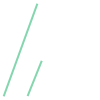

trajectory_sid: 9350359


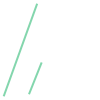

trajectory_sid: 9350186


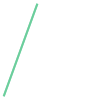

trajectory_sid: 9350286


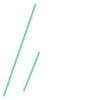

trajectory_sid: 6303093


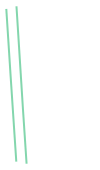

trajectory_sid: 8903258


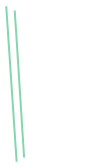

In [33]:
num_samples = 10
angered_multi_mask = clipped_trajectories.angered_clipped.map(lambda x: isinstance(x, MultiLineString))
print(angered_multi_mask.value_counts())
sample_idx = clipped_trajectories.angered_clipped[angered_multi_mask].sample(num_samples, random_state=None).index
for idx in sample_idx:
    print('trajectory_sid:', idx)
    display(clipped_trajectories.loc[idx].angered_clipped)

In [34]:
# traj_id = 9350359
# with open(f'../Data/QGIS/traj_{traj_id}.geojson', 'w') as f:
#     f.write(to_geojson(trajs_gdf_filtered.loc[traj_id].line))

In [35]:
# extract the first trajectory in the MultiLineStrings
for col in clipped_trajectories.columns:
        #is_multi_mask = clipped_trajectories[col].map(lambda x: isinstance(x, MultiLineString))
        clipped_trajectories[col] = clipped_trajectories[col].\
                map(lambda x: get_parts(x)[0] if isinstance(x, MultiLineString) else x)

In [36]:
angered_multi_mask = clipped_trajectories.angered_clipped.map(lambda x: isinstance(x, MultiLineString))
print(angered_multi_mask.value_counts())

angered_clipped
False    27584
Name: count, dtype: int64


In [37]:
# save one of them to file to look at it QGIS
# with open('../Data/QGIS/traj_16270_multi.geojson', 'w') as f:
#     f.write(to_geojson(traj_with_timestamps_df.geometry.loc[706163]))

In [38]:
clipped_trajectories[clipped_trajectories.oscarleden_clipped.notna()].oscarleden_clipped.to_csv('oscarleden_clipped_before_filter.csv', index=False)

# Heading gdf

In [39]:
columns = [name + '_heading' for name in (road_cong_names+road_free_names)]

In [40]:
heading_gdf = pd.DataFrame(index = clipped_trajectories.index, columns=columns)
heading_gdf

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading
sid,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9864756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
for col in heading_gdf.columns:
    heading_gdf[col] = clipped_trajectories[col[:-7] + 'clipped'].apply(lambda x: get_headings(x) if x != None else x)

heading_gdf[heading_gdf.angered_heading.notna()]

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading
sid,,,,,,,,,,
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,174.739983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,356.664520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,176.315363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2152,355.840590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9864716,176.227585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864726,176.279954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864754,175.939520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
heading_gdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27584 entries, 4 to 9864767
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   angered_heading      4283 non-null   float64
 1   agnesberg_heading    2443 non-null   float64
 2   torpamotet_heading   4024 non-null   float64
 3   kallebäck_heading    6034 non-null   float64
 4   riksväg_40_heading   4015 non-null   float64
 5   järnbrottet_heading  3355 non-null   float64
 6   askim_heading        1649 non-null   float64
 7   oscarleden_heading   2559 non-null   float64
 8   åbymotet_heading     5645 non-null   float64
 9   jonsered_heading     2127 non-null   float64
dtypes: float64(10)
memory usage: 3.3 MB


In [43]:
# with open('../Data/QGIS/traj_9864767.geojson', 'w') as f:
#     f.write(to_geojson(traj_with_timestamps_df.loc[9864767].line))

## Filter on headings

We should also probably include a filter on length of the clipped trajectory...

In [44]:
# Starting with an empty mask (all False values)
mask = pd.Series([False] * len(heading_gdf), index=heading_gdf.index)

for road_name in road_cong_names+road_free_names:  # Iterate over road names
    heading_thresholds = all_road_headings[road_name]
    road_column = road_name+'_heading'
    road_mask = (heading_gdf[road_column].notna())  # Start with a mask for the current road
    #print(road_name+'\n', road_mask)
    # Construct heading-based conditions for the current road
    conditions = [
        ((heading_gdf[road_column] >= threshold[0]) & (heading_gdf[road_column] <= threshold[1]))
        for threshold in heading_thresholds
    ]

    # Combine conditions with OR (|)
    combined_conditions = conditions[0]
    for condition in conditions[1:]:
        combined_conditions |= condition

    # Combine road mask with heading-based conditions using AND (&)
    road_mask &= combined_conditions
    #print('road_mask &= combined_conditions---\n', road_mask)

    # Combine with overall mask using OR (|)
    mask |= road_mask
#print('MASK:\n',mask)
#display(heading_gdf.reset_index()[mask])
# Filter the dataframe using the mask
filtered_heading_gdf = heading_gdf[mask].copy()

In [45]:
filtered_heading_gdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23400 entries, 4 to 9864767
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   angered_heading      2584 non-null   float64
 1   agnesberg_heading    2416 non-null   float64
 2   torpamotet_heading   3542 non-null   float64
 3   kallebäck_heading    5292 non-null   float64
 4   riksväg_40_heading   3909 non-null   float64
 5   järnbrottet_heading  2890 non-null   float64
 6   askim_heading        1481 non-null   float64
 7   oscarleden_heading   2172 non-null   float64
 8   åbymotet_heading     5594 non-null   float64
 9   jonsered_heading     2063 non-null   float64
dtypes: float64(10)
memory usage: 2.0 MB


In [46]:
filtered_heading_gdf

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading
sid,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.062062,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.626553
11,NaN,NaN,NaN,158.707720,NaN,NaN,NaN,NaN,154.582931,NaN
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,338.647652,NaN,NaN,NaN,NaN,334.779404,NaN
...,...,...,...,...,...,...,...,...,...,...
9864756,356.460619,NaN,NaN,NaN,326.748674,NaN,NaN,NaN,NaN,NaN
9864758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.515285,NaN
9864760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.754408,NaN


In [47]:
trajs_gdf.columns

Index(['start_time', 'stop_time', 'duration', 'data_points', 'distance',
       'speed', 'line', 'angered', 'agnesberg', 'torpamotet', 'kallebäck',
       'riksväg_40', 'järnbrottet', 'askim', 'oscarleden', 'åbymotet',
       'jonsered'],
      dtype='object')

# Hypo 1 and 3 testing this data

In [48]:
filtered_heading_gdf['speed'] = trajs_gdf.loc[filtered_heading_gdf.index, 'speed']
filtered_heading_gdf['start'] = trajs_gdf.loc[filtered_heading_gdf.index, 'start_time']
filtered_heading_gdf['end'] = trajs_gdf.loc[filtered_heading_gdf.index, 'stop_time']
filtered_heading_gdf.end = filtered_heading_gdf.end.map(lambda x: x.hour)
filtered_heading_gdf.start = filtered_heading_gdf.start.map(lambda x: x.hour)
filtered_heading_gdf

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading,speed,start,end
sid,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.062062,NaN,94.909537,4,5
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.626553,82.495549,9,10
11,NaN,NaN,NaN,158.707720,NaN,NaN,NaN,NaN,154.582931,NaN,93.235459,18,18
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.270843,11,13
14,NaN,NaN,NaN,338.647652,NaN,NaN,NaN,NaN,334.779404,NaN,75.495563,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9864756,356.460619,NaN,NaN,NaN,326.748674,NaN,NaN,NaN,NaN,NaN,106.983615,17,18
9864758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.515285,NaN,99.545104,10,11
9864760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.754408,NaN,128.913070,11,12


In [49]:
filtered_heading_gdf.groupby('start')['speed'].mean()

start
0     75.172771
1     77.174056
2     83.751421
3     79.308416
4     75.984026
5     71.432811
6     68.622250
7     72.553074
8     76.032321
9     77.477682
10    73.583148
11    74.107734
12    73.150914
13    73.181527
14    70.619205
15    68.657382
16    70.824378
17    74.927274
18    76.285255
19    76.237024
20    78.358873
21    76.020918
22    75.124765
23    78.078023
Name: speed, dtype: float64

In [50]:
tv_angered = {"location": ["angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered"],
           "hour": ["2015-11-19 23:00", "2015-11-19 00:00", "2015-11-19 01:00", "2015-11-19 02:00", "2015-11-19 03:00", "2015-11-19 04:00", "2015-11-19 05:00", "2015-11-19 06:00", "2015-11-19 07:00", "2015-11-19 08:00", "2015-11-19 09:00", "2015-11-19 10:00", "2015-11-19 11:00", "2015-11-19 12:00", "2015-11-19 13:00", "2015-11-19 14:00", "2015-11-19 15:00", "2015-11-19 16:00", "2015-11-19 17:00", "2015-11-19 18:00", "2015-11-19 19:00", "2015-11-19 20:00", "2015-11-19 21:00", "2015-11-19 22:00"],
           "mean_speed": [70.6, 74.2, 75.4, 73.2, 69.7, 73.8, 80, 88.2, 89.2, 90.5, 90.6, 87.9, 87.5, 88.2, 88.7, 86.4, 68.7, 60, 80.2, 88.5, 82.3, 75.4, 74.1, 71.1],
           "num_cars": [323, 270, 124, 93, 112, 126, 321, 880, 1430, 1265, 1093, 1177, 1424, 1770, 2049, 2412, 2996, 2893, 2265, 1570, 1152, 704, 543, 542]}

#
tv_agnesberg = {"location": ["agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg"],
           "hour": ["2018-01-09 01:00", "2018-01-09 02:00", "2018-01-09 03:00", "2018-01-09 04:00", "2018-01-09 05:00", "2018-01-09 06:00", "2018-01-09 07:00", "2018-01-09 08:00", "2018-01-09 09:00", "2018-01-09 10:00", "2018-01-09 11:00", "2018-01-09 12:00", "2018-01-09 13:00", "2018-01-09 14:00", "2018-01-09 15:00", "2018-01-09 16:00", "2018-01-09 17:00", "2018-01-09 18:00", "2018-01-09 19:00", "2018-01-09 20:00", "2018-01-09 21:00", "2018-01-09 22:00", "2018-01-09 23:00", "2018-01-09 00:00", ],
           "mean_speed": [93.3, 93.9, 93.3, 96.7, 94, 94.7, 91.3, 92.4, 91.4, 92.3, 91.9, 94.7, 93.9, 92, 91.1, 61.4, 89.1, 91.1, 91.4, 93.7, 92.6, 92.4, 92.7, 96.6],
           "num_cars": [70, 49, 43, 73, 207, 770, 1138, 998, 658, 690, 694, 809, 853, 1141, 1805, 2164, 1397, 898, 692, 509, 479, 342, 213, 123]}

tv_torpamotet = {"location": ["torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", ],
           "hour": ["2019-10-07 22:00",  "2019-10-07 23:00", "2019-10-07 00:00", "2019-10-07 01:00", "2019-10-07 02:00", "2019-10-07 03:00", "2019-10-07 04:00", "2019-10-07 05:00", "2019-10-07 06:00", "2019-10-07 07:00", "2019-10-07 08:00", "2019-10-07 09:00", "2019-10-07 10:00", "2019-10-07 11:00", "2019-10-07 12:00", "2019-10-07 13:00", "2019-10-07 14:00", "2019-10-07 15:00", "2019-10-07 16:00", "2019-10-07 17:00", "2019-10-07 18:00", "2019-10-07 19:00", "2019-10-07 20:00", "2019-10-07 21:00"],
           "mean_speed": [75.8, 77.6, 74.9, 79.8, 74.2, 79.2, 80.6, 76.3, 71.3, 61.2, 58.4, 69.6, 70.4, 68.6, 70.2, 72.2, 69.6, 69.2, 69, 70, 70.4, 71.9, 71.9, 73.6],
           "num_cars": [137, 61, 41, 25, 20, 14, 30, 170, 532, 746, 515, 418, 387, 446, 432, 384, 457, 657, 664, 461, 380, 312, 260, 273]}

tv_kalleback = {"location": ["kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", ],
           "hour": ["2019-04-04 02:00", "2019-04-04 03:00", "2019-04-04 04:00", "2019-04-04 05:00", "2019-04-04 06:00", "2019-04-04 07:00", "2019-04-04 08:00", "2019-04-04 09:00", "2019-04-04 10:00", "2019-04-04 11:00", "2019-04-04 12:00", "2019-04-04 13:00", "2019-04-04 14:00", "2019-04-04 15:00", "2019-04-04 16:00", "2019-04-04 17:00", "2019-04-04 18:00", "2019-04-04 19:00", "2019-04-04 20:00", "2019-04-04 21:00", "2019-04-04 22:00", "2019-04-04 23:00", "2019-04-04 00:00", "2019-04-04 01:00"],
           "mean_speed": [87.4, 91.4, 89.7, 89.6, 88, 71.9, 34.3, 84.5, 85.1, 85.2, 85.7, 85.6, 84.8, 42.6, 31.3, 56.2, 86.4, 89.4, 87.6, 87.9, 89.6, 90.6, 78.6, 81.4],
           "num_cars": [74, 93, 165, 164, 2381, 2710, 2336, 2003, 1870, 2047, 2100, 2179, 2446, 2357, 2014, 2348, 1942, 1357, 1054, 905, 648, 312, 234, 114]}

tv_riksvag_40 = {"location": ["riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40"],
           "hour": ["2018-09-27 22:00", "2018-09-27 23:00", "2018-09-27 00:00", "2018-09-27 01:00", "2018-09-27 02:00", "2018-09-27 03:00", "2018-09-27 04:00", "2018-09-27 05:00", "2018-09-27 06:00", "2018-09-27 07:00", "2018-09-27 08:00", "2018-09-27 09:00", "2018-09-27 10:00", "2018-09-27 11:00", "2018-09-27 12:00", "2018-09-27 13:00", "2018-09-27 14:00", "2018-09-27 15:00", "2018-09-27 16:00", "2018-09-27 17:00", "2018-09-27 18:00", "2018-09-27 19:00", "2018-09-27 20:00", "2018-09-27 21:00"],
           "mean_speed": [92.9, 95.4, 90.2, 87.5, 88, 88.1, 91.9, 90.3, 90.2, 88.7, 89.6, 90.2, 90, 89.7, 91, 91.1, 91.3, 91.2, 91.2, 82.6, 90.2, 88.9, 89.8, 89.9],
           "num_cars": [756, 356, 205, 128, 97, 158, 535, 989, 1687, 2352, 2177, 1794, 1737, 1785, 1931, 2389, 2514, 2826, 2943, 2510, 1785, 1366, 957, 782]}

df_angered = pd.DataFrame(tv_angered)
df_agnesberg = pd.DataFrame(tv_agnesberg)
df_torpamotet = pd.DataFrame(tv_torpamotet)
df_kalleback = pd.DataFrame(tv_kalleback)
df_riksvag_40 = pd.DataFrame(tv_riksvag_40)

tv_df = pd.concat([df_angered, df_agnesberg, df_torpamotet, df_kalleback, df_riksvag_40], axis=0).reset_index(drop=True)

tv_df["hour"] = pd.to_datetime(tv_df["hour"])

In [51]:
filtered_heading_gdf.columns

Index(['angered_heading', 'agnesberg_heading', 'torpamotet_heading',
       'kallebäck_heading', 'riksväg_40_heading', 'järnbrottet_heading',
       'askim_heading', 'oscarleden_heading', 'åbymotet_heading',
       'jonsered_heading', 'speed', 'start', 'end'],
      dtype='object')

In [52]:
road_df = filtered_heading_gdf.loc[:, filtered_heading_gdf.columns[:5]]
road_df = pd.concat([road_df, filtered_heading_gdf.loc[:, filtered_heading_gdf.columns[-3:]]], axis=1)
hourly_avg_speed = road_df.groupby('start')['speed'].mean()
hourly_counts = road_df.groupby('start').size()


In [53]:
road_df

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,speed,start,end
sid,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,94.909537,4,5
7,NaN,NaN,NaN,NaN,NaN,82.495549,9,10
11,NaN,NaN,NaN,158.707720,NaN,93.235459,18,18
13,176.742005,NaN,NaN,NaN,NaN,86.270843,11,13
14,NaN,NaN,NaN,338.647652,NaN,75.495563,9,10
...,...,...,...,...,...,...,...,...
9864756,356.460619,NaN,NaN,NaN,326.748674,106.983615,17,18
9864758,NaN,NaN,NaN,NaN,NaN,99.545104,10,11
9864760,NaN,NaN,NaN,NaN,NaN,128.913070,11,12


In [54]:
tv_df['plot_hour'] = tv_df['hour'].map(lambda x: x.hour)

tv_hourly_avg_speed = tv_df.groupby('plot_hour')['mean_speed'].mean().reset_index()
tv_hourly_total_cars = tv_df.groupby('plot_hour')['num_cars'].sum().reset_index()

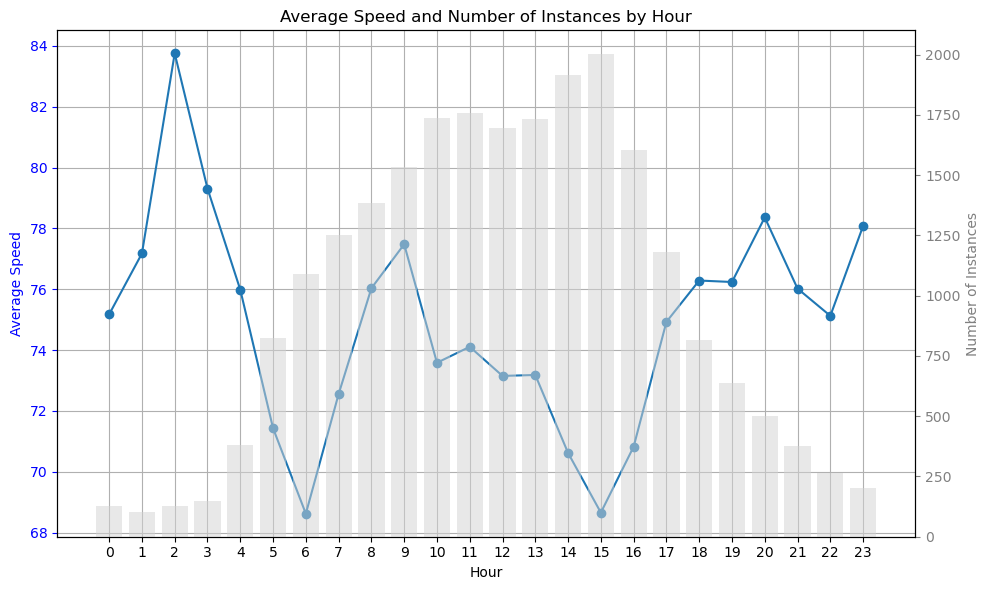

In [55]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average speed on the left y-axis
ax1.plot(hourly_avg_speed.index, hourly_avg_speed, marker='o', label='Average speed')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(hourly_avg_speed.index)

# Create a second y-axis to plot the number of instances
ax2 = ax1.twinx()
ax2.bar(hourly_counts.index, hourly_counts, color='lightgray', alpha=0.5, label='Number of Instances')
ax2.set_ylabel('Number of Instances', color='gray')
ax2.tick_params('y', colors='gray')

# Set title, grid and show the plot
plt.title('Average Speed and Number of Instances by Hour')
ax1.grid(True)
fig.tight_layout()
plt.show()



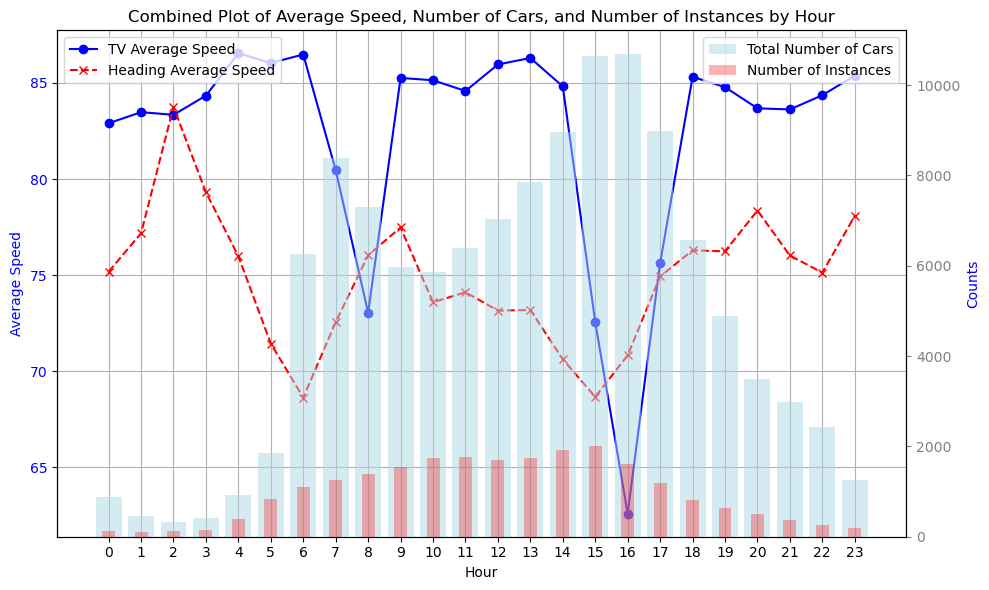

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- For tv_df data ---

# Average Speed for tv_df
ax1.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='b', label='TV Average Speed')
# Total Number of Cars
ax2 = ax1.twinx()
ax2.bar(tv_hourly_total_cars['plot_hour'], tv_hourly_total_cars['num_cars'], color='lightblue', alpha=0.5, label='Total Number of Cars')

# --- For heading_df data ---

# Average Speed for heading_df
ax1.plot(hourly_avg_speed.index, hourly_avg_speed, marker='x', linestyle='--', color='r', label='Heading Average Speed')
# Number of Instances
ax2.bar(hourly_counts.index, hourly_counts, color='red', alpha=0.3, label='Number of Instances', width=0.4)

# Labels and other plot adjustments
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')
ax1.set_xticks(tv_hourly_avg_speed['plot_hour'])

ax2.set_ylabel('Counts', color='blue')
ax2.tick_params('y', colors='gray')
ax2.legend(loc='upper right')

plt.title('Combined Plot of Average Speed, Number of Cars, and Number of Instances by Hour')
ax1.grid(True)
fig.tight_layout()
plt.show()

# Car counts

In [57]:
def count_trajs(section_names, filtered_heading_df, pprint=True):
    traj_counts = {}
    for section_name in section_names:
        filtered_col_name = section_name + '_heading'
        traj_count = filtered_heading_gdf[filtered_heading_gdf[filtered_col_name].notna()][filtered_col_name].count()
        traj_counts[section_name] = traj_count
        if pprint:
            print(f'Car count for {section_name}: \t{traj_count}')
    return traj_counts

In [58]:
first_count = count_trajs(road_cong_names+road_free_names, filtered_heading_gdf)

Car count for angered: 	2584
Car count for agnesberg: 	2416
Car count for torpamotet: 	3542
Car count for kallebäck: 	5292
Car count for riksväg_40: 	3909
Car count for järnbrottet: 	2890
Car count for askim: 	1481
Car count for oscarleden: 	2172
Car count for åbymotet: 	5594
Car count for jonsered: 	2063


In [59]:
# write full trajectories to one file per road section for investigation in QGIS

# for col_name in filtered_heading_gdf.columns:
#     section_name = col_name[:-8]
#     print(section_name)
#     count_idx = filtered_heading_gdf[filtered_heading_gdf[col_name].notna()].index
#     #display(count_idx)
#     #display(traj_with_timestamps_df[traj_with_timestamps_df.line].loc[count_idx, 'line'])
#     filepath = f'../Data/QGIS/{section_name}_filtered_full_trajectories.csv'
#     trajs_gdf_filtered.loc[count_idx, 'line'].to_csv(filepath)
#     print(f'{filepath} saved...')

In [60]:
adt_trafikverket = {'angered': [26616, 25451], 'agnesberg': [15593, 17044],
                    'torpamotet': [31315, 31970], 'kallebäck': [31655, 32208],
                    'riksväg_40': [30889, 29426], 'järnbrottet': [29670,32523],
                    'askim': [14065, 13792], 'oscarleden': [22097, 21959],
                    'åbymotet': [36715, 34790], 'jonsered': [19911,20421]}


# ÅDT from Trafikverket
for section_name in adt_trafikverket.keys():
    print(f'ÅDT for {section_name}: {adt_trafikverket[section_name]}, sum: {sum(adt_trafikverket[section_name])}')

ÅDT for angered: [26616, 25451], sum: 52067
ÅDT for agnesberg: [15593, 17044], sum: 32637
ÅDT for torpamotet: [31315, 31970], sum: 63285
ÅDT for kallebäck: [31655, 32208], sum: 63863
ÅDT for riksväg_40: [30889, 29426], sum: 60315
ÅDT for järnbrottet: [29670, 32523], sum: 62193
ÅDT for askim: [14065, 13792], sum: 27857
ÅDT for oscarleden: [22097, 21959], sum: 44056
ÅDT for åbymotet: [36715, 34790], sum: 71505
ÅDT for jonsered: [19911, 20421], sum: 40332


In [61]:
# ratio of car count to official ÅDT
ratios = {section: count / sum(adt_trafikverket[section_name]) for section, count in first_count.items()}
for section_name in road_cong_names+road_free_names:
    print(f'Ratio for {section_name}: {ratios[section_name]}') 

Ratio for angered: 0.06406823366061688
Ratio for agnesberg: 0.05990280670435386
Ratio for torpamotet: 0.08782108499454527
Ratio for kallebäck: 0.13121094912228504
Ratio for riksväg_40: 0.09692055935733412
Ratio for järnbrottet: 0.0716552613309531
Ratio for askim: 0.036720222156104335
Ratio for oscarleden: 0.05385301993454329
Ratio for åbymotet: 0.13869879996032927
Ratio for jonsered: 0.05115045125458693


- ta ett genomsnitt?
- landsväg
- Spearman

# Spearman correlation

In [62]:
from scipy.stats import spearmanr, pearsonr
#scipy.stats.spearmanr(a, b=None, axis=0, nan_policy='propagate', alternative='two-sided')

In [63]:
car_counts = [first_count[section] for section in road_cong_names+road_free_names]
adt_counts = [sum(adt_trafikverket[section]) for section in road_cong_names+road_free_names]

res = spearmanr(car_counts, b=adt_counts)

In [64]:
res.statistic

0.9272727272727272

In [65]:
res.pvalue

0.00011203450639397582

In [66]:
pear_res = pearsonr(car_counts, adt_counts)

display(pear_res.statistic, pear_res.pvalue)

0.8485600452249602

0.0019087613056262196

Text(0.5, 1.0, 'Actual ÅDT over dataset car count')

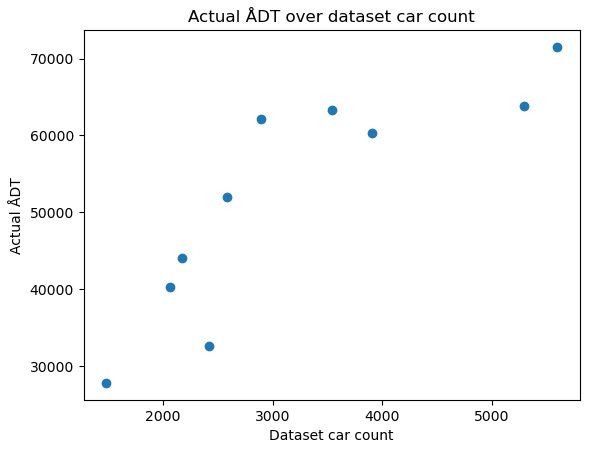

In [67]:
plt.scatter(car_counts, adt_counts)
plt.xlabel('Dataset car count')
plt.ylabel('Actual ÅDT')
plt.title('Actual ÅDT over dataset car count')

# Linear regression

In [68]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

In [69]:
X = np.array(car_counts).reshape((-1,1))
Y = np.array(adt_counts)
X,Y

(array([[2584],
        [2416],
        [3542],
        [5292],
        [3909],
        [2890],
        [1481],
        [2172],
        [5594],
        [2063]], dtype=int64),
 array([52067, 32637, 63285, 63863, 60315, 62193, 27857, 44056, 71505,
        40332]))

## Sklearn

In [70]:
model = LinearRegression()
model.fit(X,Y)
score = model.score(X,Y)
score

0.7200541503521865

In [71]:
y_pred = model.predict(X)
y_pred

array([46244.3393937 , 44711.9799281 , 54982.43682256, 70944.51458927,
       58329.91255992, 49035.42270605, 36183.66980703, 42486.41022805,
       73699.11315244, 41492.20081287])

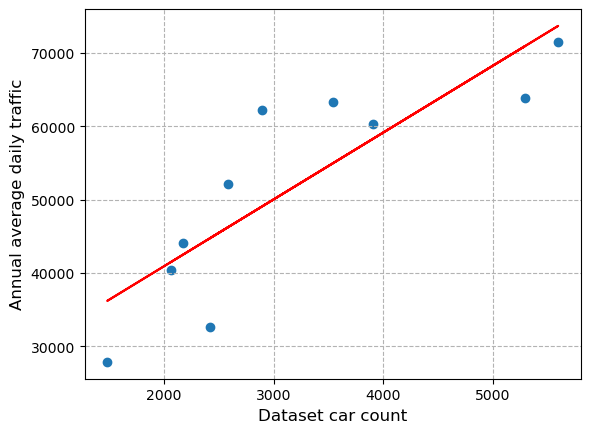

In [83]:
plt.scatter(car_counts, adt_counts)
plt.plot(car_counts, y_pred, color='r')
plt.xlabel('Dataset car count', fontsize=12)
plt.ylabel('Annual average daily traffic', fontsize=12)
#plt.title('Actual ÅDT over dataset car count', fontsize=15)
plt.grid(True, which="both", ls="--", c='0.7')
plt.savefig('figures/ÅDT_over_count.png')
plt.show()

In [73]:
display(model.coef_)
display(model.intercept_)

array([9.1211873])

22675.19142274864

In [74]:
from sklearn.metrics import mean_squared_error

In [75]:
linreg_RMSE = mean_squared_error(y_pred, Y, squared=False)
linreg_RMSE

7441.831588821583

In [76]:
errors = np.absolute(np.array(y_pred - Y))
errors

array([ 5822.6606063 , 12074.9799281 ,  8302.56317744,  7081.51458927,
        1985.08744008, 13157.57729395,  8326.66980703,  1569.58977195,
        2194.11315244,  1160.20081287])

In [77]:
errors.min(), errors.max(), np.median(errors)

(1160.2008128715315, 13157.577293947841, 6452.087597783033)

## Scipy.stats

In [78]:
X = np.array(car_counts)
slope, intercept, r_value, p_value, std_err = linregress(X,Y)

In [79]:
print('slope:', slope)
print('intercept:', intercept)
print('r_value:', r_value, 'coefficient of determination(R2):', r_value**2)
print('p_value:', p_value)
print('std_err:', std_err)

slope: 9.121187295260729
intercept: 22675.191422748652
r_value: 0.84856004522496 coefficient of determination(R2): 0.7200541503521861
p_value: 0.00190876130562623
std_err: 2.0107626879289096


In [80]:
new_sections_names = ['lundbyleden']
new_sections_adt = [22597,21149]


In [81]:
get_point(road_cong_lines[0],0).distance(get_point(road_cong_lines[0],1))

118.18196953621005

# MLP

In [82]:
feature_df = pd.DataFrame()
feature_df['section_id'] = 
feature_df['']

SyntaxError: invalid syntax (2624661516.py, line 2)

In [ ]:
points_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 13564236 entries, (945076, 1) to (552533, 9864767)
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   x          float64 
 1   y          float64 
 2   timestamp  object  
 3   geometry   geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 641.0+ MB


In [ ]:
X = np.array(car_counts).reshape((-1,1))
y = np.array(adt_counts)
X,y

(array([[2584],
        [2416],
        [3542],
        [5292],
        [3909],
        [2890],
        [1481],
        [2172],
        [5594],
        [2063]], dtype=int64),
 array([52067, 32637, 63285, 63863, 60315, 62193, 27857, 44056, 71505,
        40332]))

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
regr = MLPRegressor(random_state=42, max_iter=500).fit(X_train, y_train)
preds = regr.predict(X_test)
regr.score(X_test, y_test)

c:\Users\ander\miniconda3\envs\ox\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.37817660586353186

In [ ]:
X_train, y_train

(array([[2584],
        [2172],
        [3542],
        [2063],
        [3909],
        [5292],
        [1481]], dtype=int64),
 array([52067, 44056, 63285, 40332, 60315, 63863, 27857]))

In [ ]:
X_test, y_test, preds

(array([[5594],
        [2416],
        [2890]], dtype=int64),
 array([71505, 32637, 62193]),
 array([82374.90035853, 35584.27459319, 42563.11556637]))

# Traffic patterns
### Clustering trajectories to identify erroneous ones

In [ ]:
# feature set for learning erroneous trajectories
# trajectories that are outliers
# perhaps first with aggregates then with time series
# truncate trajectories to a bounding box around the road section

agg_features = ['max_speed', 'mean_speed', 'median_speed', 'std_speed', 'max_speed change', 'mean_speed_change', 'median_speed_change', 'std_speed_change', 'max_jerk', '']

In [ ]:
# make feature set for clustering of roads
features = ['road_width', 'speed_limit', 'lanes', 'hwy_type', 'lit', 'oneway', 'crossing'] 

# OSMnx road network

In [ ]:
selected_roads_poly = gpd.read_file('../Data/QGIS/selected_roads.geojson', crs='EPSG:3006')


In [ ]:
selected_roads_poly['EPSG:4326'] = selected_roads_poly.geometry.to_crs('EPSG:4326')

selected_roads_graph = ox.graph_from_polygon(selected_roads_poly['EPSG:4326'][0], network_type='drive', 
                                            retain_all=True, truncate_by_edge=True)

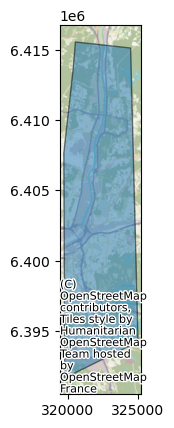

In [ ]:
ax = selected_roads_poly.plot(alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=selected_roads_poly.crs.to_string())

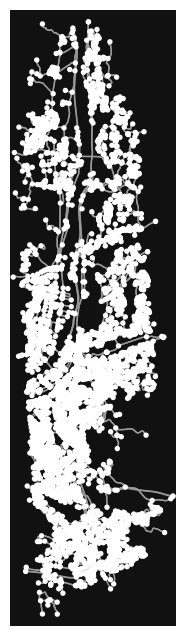

In [ ]:
fig, ax = ox.plot_graph(selected_roads_graph)

In [ ]:
ox.speed.add_edge_speeds(selected_roads_graph)
ox.speed.add_edge_travel_times(selected_roads_graph)

In [ ]:
nodes, edges = ox.graph_to_gdfs(selected_roads_graph, nodes=True, edges=True)

In [ ]:
display(nodes.sample(3), edges.sample(3))

,y,x,ref,highway,street_count,geometry
osmid,,,,,,
60891316,57.709634,11.980448,NaN,NaN,4,POINT (11.98045 57.70963)
154740436,57.655633,12.008399,NaN,NaN,3,POINT (12.00840 57.65563)
2909895900,57.728055,12.002691,NaN,NaN,3,POINT (12.00269 57.72806)


,,,osmid,oneway,lanes,highway,maxspeed,reversed,length,geometry,speed_kph,travel_time,ref,name,tunnel,bridge,junction,access,width
u,v,key,,,,,,,,,,,,,,,,,
2623405507,309984674,0,38320289,False,NaN,residential,50,True,47.665,"LINESTRING (11.98060 57.80477, 11.98046 57.804...",50.0,3.4,NaN,Skvaltkvarnsvägen,NaN,NaN,NaN,NaN,NaN
7545352954,489117,0,806863877,True,2,motorway_link,50,False,16.222,"LINESTRING (12.00494 57.68887, 12.00483 57.688...",50.0,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1639994534,1639994511,0,151178251,False,NaN,residential,50,False,42.847,"LINESTRING (12.01974 57.71365, 12.01997 57.71328)",50.0,3.1,NaN,Kyrkåsplatsen,NaN,NaN,NaN,NaN,NaN


In [ ]:
section_centroids = gpd.GeoSeries(crs='EPSG:3006')
section_geometries = gpd.GeoSeries(crs='EPSG:4326')
# get edge from graph that corresponds to the road section
for idx, section_name in enumerate(road_80_names):
    print('***', section_name, '***')
    section_centroids.append(road_80_points[idx].centroid)
     # get the closest edge to the section middle
    nearest_edge = ox.nearest_edges(selected_roads_graph, 
                                    section_centroids[idx].x, 
                                    section_centroids[idx].y)
    print(nearest_edge)
    section_geometries.append(edges.loc[nearest_edge].geometry)
    print(edges.loc[nearest_edge].osmid)



NameError: name 'road_80_names' is not defined

In [ ]:
def get_trajs_intersecting(trajs_gdf, polygon, poly_name):
    trajs_gdf[poly_name] = trajs_gdf.line.apply(lambda x: x.intersects(polygon))
    return trajs_gdf[trajs_gdf[poly_name]].index.values

In [ ]:
# to look at in QGIS
trajs_gdf[trajs_gdf[road_80_names[road_section]]].line.to_csv('road_section_trajs.csv', index=False)

In [ ]:
# 30 seconds
ax = trajs_gdf[trajs_gdf.angered].plot()
cx.add_basemap(ax, crs=trajs_gdf.crs.to_string())

In [ ]:
angered_boundary = gpd.read_file('../Data/QGIS/angered_roads.geojson', crs='EPSG:3006')
ax = angered_boundary.plot(alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=angered_boundary.crs.to_string())

In [ ]:
trajs_clipped = trajs_gdf[trajs_gdf.angered].clip(angered_boundary)
ax = trajs_clipped[trajs_clipped.angered].plot()
cx.add_basemap(ax, crs=trajs_clipped.crs.to_string())

In [ ]:
trajs_clipped.line.to_csv('../Data/QGIS/angered_trajs.csv', index=False)

for OSMnx to work we need to transform boundary polygon crs to EPSG:4326

In [ ]:
angered_boundary['EPSG:4326'] = angered_boundary.geometry.to_crs('EPSG:4326')
angered_boundary

In [ ]:
angered_roads_graph = ox.graph_from_polygon(angered_boundary['EPSG:4326'][0], network_type='drive', 
                                            retain_all=True, truncate_by_edge=True)

In [ ]:
fig, ax = ox.plot_graph(angered_roads_graph)

In [ ]:
ox.basic_stats(angered_roads_graph)

In [ ]:
edge_centrality = nx.closeness_centrality(nx.line_graph(angered_roads_graph))
nx.set_edge_attributes(angered_roads_graph, edge_centrality, 'edge_centrality')

In [ ]:
ec = ox.plot.get_edge_colors_by_attr(angered_roads_graph, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(angered_roads_graph, edge_color=ec, edge_linewidth=2, node_size=0)

In [ ]:
angered_roads_graph = ox.speed.add_edge_speeds(angered_roads_graph)
angered_roads_graph = ox.speed.add_edge_travel_times(angered_roads_graph)
angered_roads_graph

In [ ]:
nodes, edges = ox.utils_graph.graph_to_gdfs(angered_roads_graph)

In [ ]:
nodes

In [ ]:
edges.head(2)

In [ ]:
edge = ox.nearest_edges(angered_roads_graph, 322169, 6411344)
edge

In [ ]:
with open('../Data/QGIS/powerpipe_poly.geojson', 'r') as f:
    powerpipe_poly = from_geojson(f.read())
powerpipe_poly

In [ ]:
powerpipe_trajs = get_trajs_intersecting(trajs_gdf[trajs_gdf.powerpipe], powerpipe_poly, 'powerpipe')
powerpipe_trajs

In [ ]:
trajs_gdf[trajs_gdf.powerpipe].line.to_csv('../Data/QGIS/powerpipe_trajs.csv', index=False)

In [ ]:
with open('../Data/QGIS/traj_from_dot.geojson', 'r') as f:
    traj_from_dot_poly = from_geojson(f.read())
traj_from_dot_poly

In [ ]:
traj_from_dot = get_trajs_intersecting(trajs_gdf[trajs_gdf.powerpipe], traj_from_dot_poly, 'traj_from_dot')

In [ ]:
traj_from_dot[0]

In [ ]:
with open('../Data/QGIS/traj_from_dot.geojson', 'w') as f:
    f.write(to_geojson(trajs_gdf.loc[traj_from_dot[0]].line))

In [ ]:
edges.loc[edge]

In [ ]:
edges.loc[(147275, 8718064002)] 